## initial mapping workflow for supratidal forests (STF)
- works on geojson GA coastal tiles `../data/geojson/ga_summary_grid_c3_coastal.geojson`
- select `time_range` and if to `export` results as tif

In [59]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# pd.set_option('display.max_rows', None)

sys.path.insert(1, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
dc = datacube.Datacube()

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')


# custom functions
sys.path.insert(2, "/home/jovyan/code/supratidal_forests/functions")
import terrain

## user inputs: tile, time and export geotiffs?

In [60]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

### using GA coastal tiles geojson

In [61]:
# GA coastal tiles
vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()


### select the tile of interest (click on map above and find value for `id` and manually select using `loc` below)

In [62]:
gdf = mainland_grid.loc[mainland_grid['id'] == 140
                    ]

In [63]:
gdf.explore()

In [64]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}


In [65]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}



Feature: 140/1


### load strm, slope, item, mangroves

In [66]:
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm = srtm_ds.dem_h



#Load Slope
# using dem_h here as results seem to be more alligned with QGIS slope function (gdaldem implementation)
# this throws warnings and results in some areas be 90 degrees slope (obviously wrong) around the edge of coastlines and rivers
shadows, slope, sia = terrain.shadows_and_slope(tile=srtm_ds.squeeze(), time=srtm_ds.dem.time.values, elevation_var='dem')

#This appears to be used to convert an array (slope) into a dataarray (slope_xr)- Raf
slope_xr = xr.DataArray(data=slope, coords=srtm_ds.squeeze().coords, dims=srtm_ds.squeeze().dims, attrs=srtm_ds.squeeze().attrs)


# Load item
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative

# Load in mangrove cover
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)
    
    
    


/home/jovyan/code/supratidal_forests/functions/terrain.py:126: RuntimeWarning: overflow encountered in multiply
  norm_len = numpy.sqrt((xgrad * xgrad) + (ygrad * ygrad) + 1.0)
/home/jovyan/code/supratidal_forests/functions/terrain.py:132: RuntimeWarning: invalid value encountered in subtract
  sia = (solar_vec[2] - (xgrad * solar_vec[0]) - (ygrad * solar_vec[1])) / norm_len
/home/jovyan/code/supratidal_forests/functions/terrain.py:132: RuntimeWarning: invalid value encountered in divide
  sia = (solar_vec[2] - (xgrad * solar_vec[0]) - (ygrad * solar_vec[1])) / norm_len


### load in woody cover virtual product

In [67]:
# load in vp woody cover
sys.path.insert(1, '../virtual_products') 
# The dictionary which datacube uses to understand (resolve) the different virtual product functionality
# Need to add any aggregations for the VP you're using

# Get location of transformation
aggregation = "best_pixel_gmad"
agg_loc = importlib.import_module(aggregation)
agg_class = aggregation.split('.')[-1]

DEFAULT_RESOLVER.register('aggregate', agg_class, getattr(agg_loc, agg_class) )

VirtualProductException: name best_pixel_gmad under aggregate is already registered

In [68]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "woody_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

VirtualProductException: name woody_cover under transform is already registered

In [69]:
# load woody_cover vp
product = catalog['woody_cover']
woody_cover_vp = product.load(dc, **query)

# # woody cover with threshold for saltmarsh
woody_cover = xr.where(woody_cover_vp.woody_cover > 0.5, 1, 0).astype('int8')
woody_cover.attrs['crs'] = 'EPSG:3577'

/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### create initial supratidal forest extent product

In [70]:
## wrangle binary maps and create STF mask

# not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1

# greater than 1m AHD and less than 10m AHD == True
#Modified upper limit from 10 m to 5 m

AHD_min = 1
#AHD_max = 5
AHD_max = 10

# SRTM
lessthan10m_AHD = srtm <= AHD_max
greaterthan1m_AHD = srtm >= AHD_min
AHD_threshold_srtm = lessthan10m_AHD & greaterthan1m_AHD

#Slope
Slope_min = 1
Slope_5 = 5
Slope_10 = 10
Slope_15 = 15
Slope_max = 20

lessthan20_Slope = slope_xr <= Slope_max
lessthan15_Slope = slope_xr <= Slope_15
lessthan10_Slope = slope_xr <= Slope_10
lessthan5_Slope = slope_xr <= Slope_5
greaterthan1_Slope = slope_xr >= Slope_min

Slope_1_20 = lessthan20_Slope & greaterthan1_Slope
Slope_1_15 = lessthan15_Slope & greaterthan1_Slope
Slope_1_10 = lessthan10_Slope & greaterthan1_Slope
Slope_1_5 = lessthan5_Slope & greaterthan1_Slope

# item (remove all intertidal areas)
not_intertidal = item == 9

# remove time dim
not_mangrove = not_mangrove.squeeze('time')
AHD_threshold_srtm = AHD_threshold_srtm.squeeze('time')
not_intertidal = not_intertidal.squeeze('time')

In [71]:
# combine masks
STF = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')
STF_Slope_1_20 = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (Slope_1_20 == False) +(not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')
STF_Slope_1_15 = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (Slope_1_15 == False) +(not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')
STF_Slope_1_10 = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (Slope_1_10 == False) +(not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')
STF_Slope_1_5 = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (Slope_1_5 == False) +(not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')

In [72]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, srtm_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
STF = STF.where(mask)
STF_Slope_1_20 = STF_Slope_1_20.where(mask)
STF_Slope_1_15 = STF_Slope_1_15.where(mask)
STF_Slope_1_10 = STF_Slope_1_10.where(mask)
STF_Slope_1_5 = STF_Slope_1_5.where(mask)

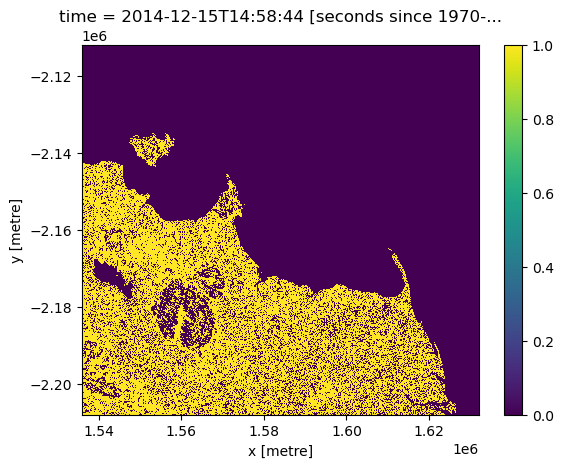

In [73]:
Slope_1_20.plot()

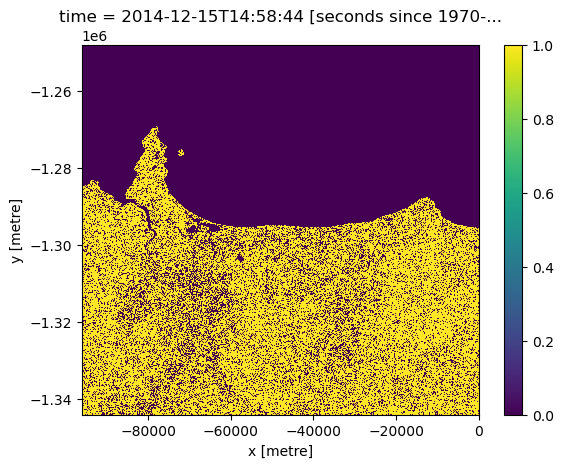

In [37]:
Slope_1_5.plot()

### combine inputs and output to 16 band xarray dataset
- band 1: mangrove (1), no mangrove (0)
- band 2: SRTM data (raw elevation values)
- band 3: SRTM threshold between 1-10 (1), outside this range (0)
- band 4: ITEMs intertidal areas (1), non intertidal areas (0)
- band 5: woody cover fraction data (raw fraction values 0-1)
- band 6: woody cover fraction threshold >0.5 (1), <0.5 (0)
- band 7: Slope data (raw slope values)
- band 8: Slope data threshold between 1-20 (1), outside this range (0)
- band 9: Slope data threshold between 1-15 (1), outside this range (0)
- band 10: Slope data threshold between 1-10 (1), outside this range (0)
- band 11: Slope data threshold between 1-5 (1), outside this range (0)
- band 12: STF present (1), STF absent (0)
- band 13: STF_Slope_1_20 present (1), STF absent (0)
- band 14: STF_Slope_1_15 present (1), STF absent (0)
- band 15: STF_Slope_1_10 present (1), STF absent (0)
- band 16: STF_Slope_1_5 present (1), STF absent (0)

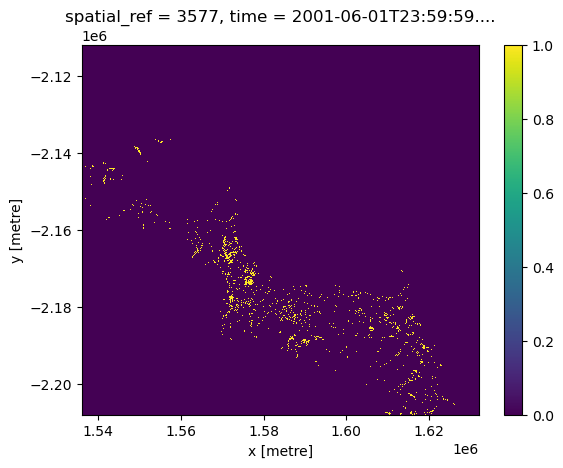

In [74]:
STF.plot()

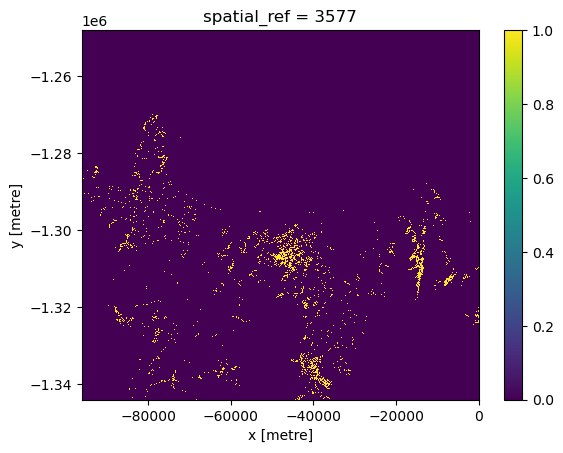

In [39]:
STF_Slope_1_20.plot()

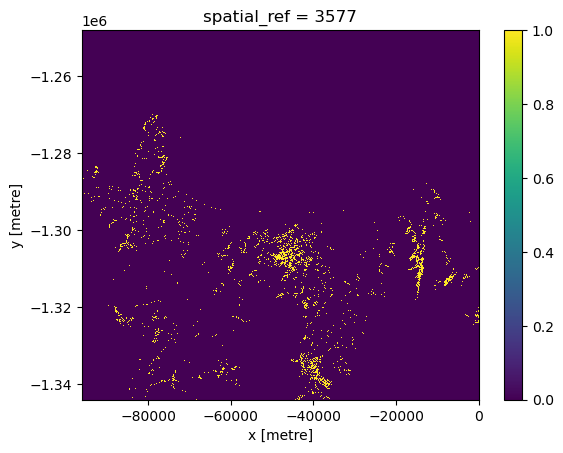

In [40]:
STF_Slope_1_15.plot()

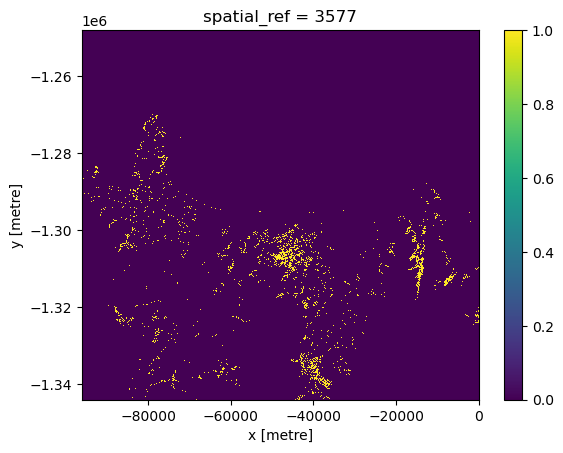

In [41]:
STF_Slope_1_10.plot()

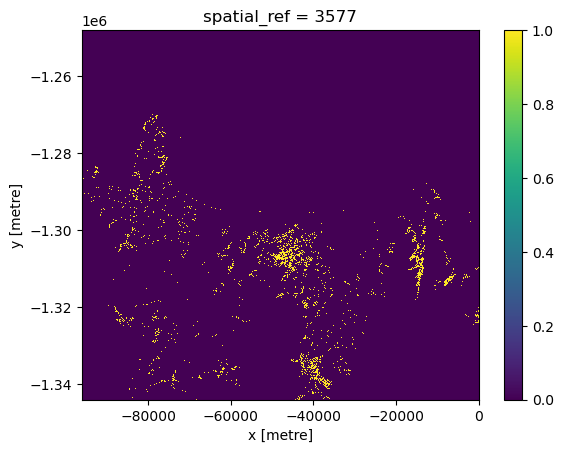

In [42]:
STF_Slope_1_5.plot()

In [81]:
# make all into datasets and merge
variables_xarray_list = []

# band 1
mangrove_ds = mangrove.to_dataset(name="mangrove").squeeze().drop('time')
variables_xarray_list.append(mangrove_ds)

# band 2
srtm_false_value_remove = xr.where(srtm < -10 ,0, srtm.values)
srtm_ds = srtm_false_value_remove.to_dataset(name="SRTM").squeeze().drop('time')
variables_xarray_list.append(srtm_ds)

# band 3
AHD_threshold_srtm_ds = AHD_threshold_srtm.to_dataset(name="SRTM_threshold").squeeze().drop('time')
variables_xarray_list.append(AHD_threshold_srtm_ds)

# band 4
intertidal = xr.where(not_intertidal == True, 0, 1).astype('int8')
intertidal_ds = intertidal.to_dataset(name="intertidal_and_below").squeeze().drop('time')
variables_xarray_list.append(intertidal_ds)

# band 5
woody_cover_raw = woody_cover_vp.woody_cover
woody_cover_raw_mask_intertidal = woody_cover_raw.where(not_intertidal) # mask by intertidal due to WCF values in water that are erronous (note this means areas in the intertidal are not masked for WCF, which we actually may want to know about for STF vs saltmarsh)
woody_cover_raw_mask_intertidal_ds = woody_cover_raw_mask_intertidal.to_dataset(name="woody_cover").squeeze()
variables_xarray_list.append(woody_cover_raw_mask_intertidal_ds)

# band 6
woody_cover_threshold_ds = woody_cover.to_dataset(name="woody_cover_threshold").squeeze()
variables_xarray_list.append(woody_cover_threshold_ds)

# band 7
slope_xr_false_value_remove = xr.where(slope_xr == 90 , 0, slope_xr.values) # remove weird values due to hydrologically corrected DEM with slope pixels of 90 degrees at waters edge
slope_xr_ds = slope_xr_false_value_remove.to_dataset(name="slope").squeeze().drop('time')
variables_xarray_list.append(slope_xr_ds)



# band 8
Slope_1_20_ds = Slope_1_20.to_dataset(name="Slope_1_20").squeeze().drop('time')
variables_xarray_list.append(Slope_1_20_ds)

# band 9
Slope_1_15_ds = Slope_1_15.to_dataset(name="Slope_1_15").squeeze().drop('time')
variables_xarray_list.append(Slope_1_15_ds)

# band 10
Slope_1_10_ds = Slope_1_10.to_dataset(name="Slope_1_10").squeeze().drop('time')
variables_xarray_list.append(Slope_1_10_ds)

# band 11
Slope_1_5_ds = Slope_1_5.to_dataset(name="Slope_1_5").squeeze().drop('time')
variables_xarray_list.append(Slope_1_5_ds)



# band 12
STF_ds = STF.to_dataset(name="STF").astype('int8')#.squeeze().drop('time')
variables_xarray_list.append(STF_ds)

# band 13
STF_Slope_1_20_ds = STF_Slope_1_20.to_dataset(name="STF_Slope_1_20").astype('int8')#.squeeze().drop('time')
variables_xarray_list.append(STF_Slope_1_20_ds)

# band 14
STF_Slope_1_15_ds = STF_Slope_1_15.to_dataset(name="STF_Slope_1_15").astype('int8')#.squeeze().drop('time')
variables_xarray_list.append(STF_Slope_1_15_ds)

# band 15
STF_Slope_1_10_ds = STF_Slope_1_10.to_dataset(name="STF_Slope_1_10").astype('int8')#.squeeze().drop('time')
variables_xarray_list.append(STF_Slope_1_10_ds)

# band 16
STF_Slope_1_5_ds = STF_Slope_1_5.to_dataset(name="STF_Slope_1_5").astype('int8')#.squeeze().drop('time')
variables_xarray_list.append(STF_Slope_1_5_ds)

stacked_xarray = xr.merge(variables_xarray_list)

In [83]:
Slope_1_20_ds.Slope_1_20.dtype

dtype('bool')

In [58]:
STF_Slope_1_5_ds.STF_Slope_1_5.dtype


dtype('int8')

### output to geotiff

In [84]:
def set_band_names(input_img: str, band_names: list, feedback: bool = False):
    """
    NOTE: Function is from RSGISlib that is not avaliable on DEA sandbox
    A utility function to set band names.

    :param input_img: input image file.
    :param band_names: is a list of band names
    :param feedback: is a boolean specifying whether feedback will be printed to the
                     console (True= Printed / False (default) Not Printed)

    .. code:: python

        from rsgislib import imageutils

        input_img = 'injune_p142_casi_sub_utm.kea'
        band_names = ['446nm','530nm','549nm','569nm','598nm','633nm','680nm','696nm',
                      '714nm','732nm','741nm','752nm','800nm','838nm']

        imageutils.set_band_names(input_img, band_names)

    """
    dataset = gdal.Open(input_img, gdal.GA_Update)

    for i in range(len(band_names)):
        band = i + 1
        bandName = band_names[i]

        imgBand = dataset.GetRasterBand(band)
        # Check the image band is available
        if not imgBand is None:
            if feedback:
                print('Setting Band {0} to "{1}"'.format(band, bandName))
            imgBand.SetDescription(bandName)
        else:
            raise rsgislib.RSGISPyException("Could not open the image band: ", band)
            

#Kernel dies here and exports wrong Values to tif file

In [85]:
if export == False:
    pass
else:
    write_cog(geo_im=stacked_xarray.to_array(),
              fname='initial_STF_model_coastal_tile_gridID_' + gdf['id'].astype(str).item() +'_year_' + time_range[0] + '.tif',
              overwrite=True,
              nodata=0.0)

    input_img = 'initial_STF_model_coastal_tile_gridID_' + gdf['id'].astype(str).item() +'_year_' + time_range[0] + '.tif'
    band_names = list(stacked_xarray.data_vars.keys())
    set_band_names(input_img, band_names)